# Documentation

In [1]:
from IPython.core.display import HTML
HTML("""<style>
    .MathJax_Display { font-size: 23px; }
</style>""")

$$
\theta = \theta + \alpha (r + \gamma max_{a'} Q(s',a') - Q(s,a)) \nabla_{\theta} Q(s,a)
$$

# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import sys


for p in ['..', '../..', '../../..', '../../../..']:
    d = os.path.abspath(p)
    if d not in sys.path:
        sys.path.insert(0,d)
    
"""
Add tiger-env directory to current path
Still not sure why this is needed.
"""
d = [os.path.abspath('../../../../../custom_envs/gym-tiger'),
    os.path.abspath('../../../../../custom_envs/gym-dummy/')]
for _d in d:
    if _d not in sys.path:
        sys.path.insert(0, _d)
    

"""
Enable hot-reloading
"""    
from notebook_utils import import_module_by_name, reload_module_by_name

def reload():
    reload_module_by_name('research.neural_networks.mlp', 'ReLU')
    reload_module_by_name('research.neural_networks.mlp', 'Sigmoid')
    reload_module_by_name('research.neural_networks.mlp', 'MLPRegressor')
    reload_module_by_name(
        'experiments.qlearning.dqn.dqn_seq_obs.numpy_seq_dqn',
        'NumpySeqDQN')
    global ReLU, Sigmoid, MLPRegressor
    global NumpySeqDQN
    from research.neural_networks.mlp import ReLU, MLPRegressor
    from experiments.qlearning.dqn.dqn_seq_obs.numpy_seq_dqn \
        import NumpySeqDQN
    
    
import gym
import matplotlib.pyplot as plt
from tabulate import tabulate

from research.neural_networks.mlp import MLPRegressor, ReLU, Sigmoid
from experiments.qlearning.dqn.dqn_seq_obs.numpy_seq_dqn \
    import NumpySeqDQN, play_one, main, running_avg, plot_running_avg

# TwoInARow-v0


Obs. Seq      Action 0    Action 1
----------  ----------  ----------
0,0           0.354684     1.17883
1,1           0.344861     1.07494
0,1           0.350624     1.06646
1,0           0.349029     1.16207

too few experiences 1
too few experiences 2
too few experiences 3

Obs. Seq      Action 0    Action 1
----------  ----------  ----------
0,0            1.25892     1.57613
1,1            1.24232     1.47186
0,1            1.24118     1.45582
1,0            1.25838     1.56509

episode: 0 total reward: -16 eps: 1.0 avg reward (last 50): -16.0

Obs. Seq      Action 0    Action 1
----------  ----------  ----------
0,0            1.74786     2.32842
1,1            1.70189     1.50699
0,1            1.69699     1.57442
1,0            1.75077     1.7135

episode: 50 total reward: 26 eps: 0.45549746548537273 avg reward (last 50): 4.588235294117647

Obs. Seq      Action 0    Action 1
----------  ----------  ----------
0,0            2.3011      3.26908
1,1            1.94031     1.9122

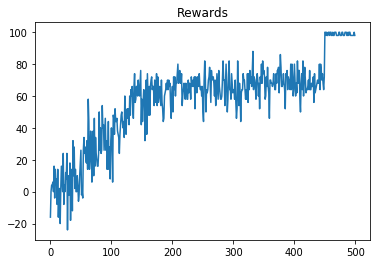

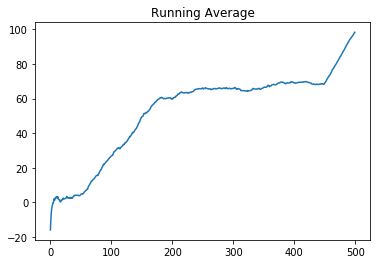

In [46]:
from copy import deepcopy
import gym_dummy

env = gym.make('TwoInARow-v0')
env.__init__(max_steps_per_episode=100)
copy_period = 10
gamma = 0.9
start_obs = env.reset()
obs_seq_len = 2
D = obs_seq_len * 1
K = env.action_space.n
hidden_layer_sizes = [3, 3]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': Sigmoid(),
                     'learning_rate': 1e-2,
                     'mu': .7}
model = NumpySeqDQN(env, D, K, hidden_layer_opts, gamma, obs_seq_len,
                    start_obs, min_experiences=4)

N = 500
totalrewards = np.zeros(N)


print(model)

window = int(N/10)
for n in range(N):
    if n >= (N - window):
        eps = 0
    else:
        eps = 1.0/(n+1)**.2
    totalreward = play_one(env, model, eps, gamma, copy_period,
                           store_seq_counts=False)
    totalrewards[n] = totalreward
    if window > 0 and n % window == 0:
        print(model)
        ravg = running_avg(totalrewards, n, window)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last {}):'.format(window), ravg)

print(model)        


print('avg reward for last {} episodes:'.format(window),
      totalrewards[-window:].mean())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards, window)

# Cartpole-v0

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
too few experiences 1
too few experiences 2
too few experiences 3
too few experiences 4
episode: 0 total reward: 43.0 eps: 1.0 avg reward (last 10): 43.0
episode: 100 total reward: 34.0 eps: 0.2504399381545132 avg reward (last 10): 14.673267326732674
episode: 200 total reward: 12.0 eps: 0.20372352531302257 avg reward (last 10): 13.871287128712872
episode: 300 total reward: 8.0 eps: 0.18048040269604865 avg reward (last 10): 13.693069306930694
episode: 400 total reward: 12.0 eps: 0.16559861042956964 avg reward (last 10): 14.633663366336634
episode: 500 total reward: 11.0 eps: 0.15489902432419686 avg reward (last 10): 16.88118811881188
episode: 600 total reward: 26.0 eps: 0.14666877287047164 avg reward (last 10): 17.96039603960396
episode: 700 total reward: 16.0 eps: 0.14005047773456306 avg reward (last 10): 17.663366336633665
episode: 800 total reward: 24.0 eps: 0.1345582236363188 avg rewar

episode: 8200 total reward: 49.0 eps: 0.06696377930829248 avg reward (last 10): 49.26732673267327
episode: 8300 total reward: 38.0 eps: 0.06672074329130369 avg reward (last 10): 50.26732673267327
episode: 8400 total reward: 37.0 eps: 0.06648148390503952 avg reward (last 10): 45.43564356435643
episode: 8500 total reward: 45.0 eps: 0.06624589854511533 avg reward (last 10): 47.693069306930695
episode: 8600 total reward: 52.0 eps: 0.0660138885600565 avg reward (last 10): 46.53465346534654
episode: 8700 total reward: 55.0 eps: 0.0657853590551499 avg reward (last 10): 49.10891089108911
episode: 8800 total reward: 43.0 eps: 0.06556021870815536 avg reward (last 10): 47.415841584158414
episode: 8900 total reward: 54.0 eps: 0.065338379596034 avg reward (last 10): 48.45544554455446
episode: 9000 total reward: 59.0 eps: 0.06511975703191979 avg reward (last 10): 47.97029702970297
episode: 9100 total reward: 62.0 eps: 0.06490426941162203 avg reward (last 10): 47.40594059405941
episode: 9200 total re

episode: 16500 total reward: 38.0 eps: 0.0542933851864367 avg reward (last 10): 67.23762376237623
episode: 16600 total reward: 51.0 eps: 0.05419506295653634 avg reward (last 10): 71.08910891089108
episode: 16700 total reward: 161.0 eps: 0.05409750767442616 avg reward (last 10): 79.66336633663366
episode: 16800 total reward: 58.0 eps: 0.05400070881886031 avg reward (last 10): 71.56435643564356
episode: 16900 total reward: 67.0 eps: 0.053904656074453355 avg reward (last 10): 67.93069306930693
episode: 17000 total reward: 70.0 eps: 0.053809339326462736 avg reward (last 10): 66.84158415841584
episode: 17100 total reward: 24.0 eps: 0.053714748655733315 avg reward (last 10): 64.84158415841584
episode: 17200 total reward: 32.0 eps: 0.05362087433379782 avg reward (last 10): 64.67326732673267
episode: 17300 total reward: 33.0 eps: 0.053527706818127976 avg reward (last 10): 58.92079207920792
episode: 17400 total reward: 59.0 eps: 0.05343523674753031 avg reward (last 10): 62.26732673267327
episod

episode: 24800 total reward: 79.0 eps: 0.04804622185161507 avg reward (last 10): 65.23762376237623
episode: 24900 total reward: 40.0 eps: 0.047988255615614026 avg reward (last 10): 64.22772277227723
episode: 25000 total reward: 71.0 eps: 0.0479305912151871 avg reward (last 10): 64.60396039603961
episode: 25100 total reward: 100.0 eps: 0.04787322588075014 avg reward (last 10): 61.76237623762376
episode: 25200 total reward: 58.0 eps: 0.047816156879036543 avg reward (last 10): 61.524752475247524
episode: 25300 total reward: 71.0 eps: 0.04775938151247911 avg reward (last 10): 63.65346534653465
episode: 25400 total reward: 65.0 eps: 0.04770289711860489 avg reward (last 10): 65.75247524752476
episode: 25500 total reward: 69.0 eps: 0.0476467010694426 avg reward (last 10): 62.32673267326733
episode: 25600 total reward: 80.0 eps: 0.04759079077094232 avg reward (last 10): 65.39603960396039
episode: 25700 total reward: 46.0 eps: 0.04753516366240722 avg reward (last 10): 59.20792079207921
episode:

episode: 33100 total reward: 84.0 eps: 0.04406032189874181 avg reward (last 10): 100.2871287128713
episode: 33200 total reward: 88.0 eps: 0.0440204675126646 avg reward (last 10): 103.81188118811882
episode: 33300 total reward: 149.0 eps: 0.043980768873490644 avg reward (last 10): 104.60396039603961
episode: 33400 total reward: 63.0 eps: 0.04394122490761658 avg reward (last 10): 76.72277227722772
episode: 33500 total reward: 55.0 eps: 0.043901834552025606 avg reward (last 10): 64.78217821782178
episode: 33600 total reward: 55.0 eps: 0.04386259675415187 avg reward (last 10): 71.07920792079207
episode: 33700 total reward: 99.0 eps: 0.04382351047174696 avg reward (last 10): 80.63366336633663
episode: 33800 total reward: 150.0 eps: 0.04378457467274853 avg reward (last 10): 83.47524752475248
episode: 33900 total reward: 77.0 eps: 0.043745788335151 avg reward (last 10): 70.02970297029702
episode: 34000 total reward: 69.0 eps: 0.04370715044687816 avg reward (last 10): 71.56435643564356
episode

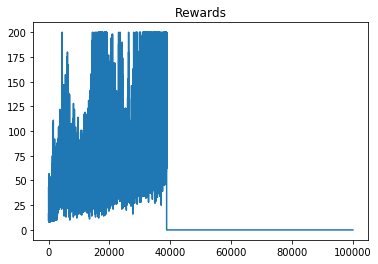

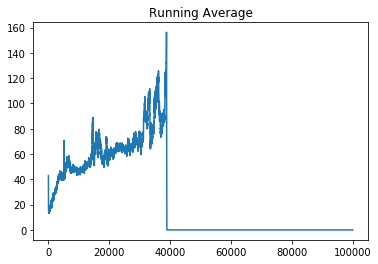

In [75]:
from copy import deepcopy

env = gym.make('CartPole-v0')
copy_period = 10
batch_size = 32
gamma = 0.8
start_obs = env.reset()
obs_seq_len = 2
D = obs_seq_len * len(env.observation_space.sample())
K = env.action_space.n
hidden_layer_sizes = [3000, 25]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': ReLU(),
                     'learning_rate': 1e-5,
                     'mu': .4}
model = NumpySeqDQN(env, D, K, hidden_layer_opts, gamma, obs_seq_len, start_obs)

N = int(1e5)
totalrewards = np.zeros(N

window = int(N/1000)
for n in range(N):
    eps = 1.0/(n+1)**.3
    totalreward = play_one(env, model, eps, gamma, copy_period,
                           store_seq_counts=False)
    totalrewards[n] = totalreward
    if n % window == 0:
        ravg = running_avg(totalrewards, n, window)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 10):', ravg)
        if ravg > 150:
            break


print('avg reward for last 10 episodes:', totalrewards[-10:].mean())
print('total steps:', totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards, window)

# Tiger-v0

In [167]:
import gym_tiger
OBS_GROWL_LEFT = [1, 0, 0]
OBS_GROWL_RIGHT = [0, 1, 0]
OBS_START = [0, 0, 1]

ACTION_OPEN_LEFT = 0
ACTION_OPEN_RIGHT = 1
ACTION_LISTEN = 2
ACTION_MAP = {
    ACTION_OPEN_LEFT: 'OPEN_LEFT',
    ACTION_OPEN_RIGHT: 'OPEN_RIGHT',
    ACTION_LISTEN: 'LISTEN',
}

from copy import deepcopy

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1,
             max_steps_per_episode=100)
gamma = 0.99
start_obs = env.reset()

obs_seq_len = 2
hidden_layer_sizes = [15, 15]
copy_period = 10
D = obs_seq_len * env.observation_space.n
K = env.action_space.n
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': Sigmoid(),
                     'learning_rate': 1e-4,
                    'mu': .3}
model = NumpySeqDQN(env, D, K, hidden_layer_opts, gamma, obs_seq_len, start_obs)

N = 1000
totalrewards = np.zeros(N)

obs_perms = [
    [OBS_START, OBS_START],
    [OBS_START, OBS_GROWL_LEFT],
    [OBS_START, OBS_GROWL_RIGHT],
    [OBS_GROWL_LEFT, OBS_START],
    [OBS_GROWL_LEFT, OBS_GROWL_LEFT],
    [OBS_GROWL_LEFT, OBS_GROWL_RIGHT],
    [OBS_GROWL_RIGHT, OBS_START],
    [OBS_GROWL_RIGHT, OBS_GROWL_LEFT],
    [OBS_GROWL_RIGHT, OBS_GROWL_RIGHT],
]

window = int(N/10)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
#     eps = 1/(n+1)**(1/5)
    totalreward = play_one(env, model, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % window == 0:
        ravg = running_avg(totalrewards, n, window)
        print('\nepisode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 100):', ravg)
        Q = []
        for perm in obs_perms:
            o1, o2 = perm
            _o1 = env.translate_obs(o1)
            _o2 = env.translate_obs(o2)
            pred = model.predict([o1, o2])
            best_action_idx = np.argmax(pred[0])
            action_values = pred[0].astype(str)
            action_values[best_action_idx] = action_values[best_action_idx] + ' <<'
            a_openl, a_openr, a_listen = action_values
            Q.append([_o1, _o2, a_openl, a_openr, a_listen])
        print('\n' + tabulate(Q, headers=['obs1', 'obs2', 'OPEN LEFT Q Value', 'OPEN RIGHT Q Value', 'LISTEN Q Value']))
#         display(sorted(model.train_obs_seq_counts.items(), key=lambda x: x[1], reverse=True))
#         display(sorted(model.train_obs_seq_action_counts.items(), key=lambda x: x[1], reverse=True))


print('avg reward for last 100 episodes:', totalrewards[-10:].mean())
print('total steps:', totalrewards.sum())

too few experiences 1
too few experiences 2
too few experiences 3
too few experiences 4

episode: 0 total reward: -3268 eps: 1.0 avg reward (last 100): -3268.0

obs1         obs2         OPEN LEFT Q Value       OPEN RIGHT Q Value        LISTEN Q Value
-----------  -----------  ----------------------  ----------------------  ----------------
START        START        -0.8064675355101041 <<  -1.0143945785695938             -1.13395
START        GROWL_LEFT   -0.9244094440216649 <<  -1.0948996107897258             -1.17167
START        GROWL_RIGHT  -0.7823603591992111 <<  -1.1853156432655723             -1.18984
GROWL_LEFT   START        -0.9706862765147469     -0.9434909643078186 <<          -1.12807
GROWL_LEFT   GROWL_LEFT   -1.0463067120431944     -1.0269549548562025 <<          -1.18085
GROWL_LEFT   GROWL_RIGHT  -0.9499876514664068 <<  -1.1121063092962669             -1.19987
GROWL_RIGHT  START        -0.7669278072764333 <<  -0.9482381874282945             -1.13663
GROWL_RIGHT  GROWL_L

KeyboardInterrupt: 

In [160]:
model.train_obs_seq_counts

{'GROWL_LEFT, GROWL_LEFT': 12416,
 'GROWL_LEFT, GROWL_RIGHT': 12556,
 'GROWL_RIGHT, GROWL_RIGHT': 12307,
 'START, GROWL_LEFT': 51,
 'GROWL_RIGHT, GROWL_LEFT': 12522,
 'GROWL_LEFT, START': 57,
 'START, GROWL_RIGHT': 43,
 'GROWL_RIGHT, START': 44}

In [161]:
model.train_obs_seq_action_counts

{'GROWL_LEFT, GROWL_LEFT => OPEN_LEFT': 1002,
 'GROWL_LEFT, GROWL_LEFT => LISTEN': 10336,
 'GROWL_LEFT, GROWL_RIGHT => OPEN_RIGHT': 999,
 'GROWL_RIGHT, GROWL_RIGHT => OPEN_LEFT': 943,
 'GROWL_RIGHT, GROWL_RIGHT => LISTEN': 10421,
 'START, GROWL_LEFT => LISTEN': 48,
 'GROWL_RIGHT, GROWL_RIGHT => OPEN_RIGHT': 943,
 'GROWL_LEFT, GROWL_LEFT => OPEN_RIGHT': 1078,
 'GROWL_LEFT, GROWL_RIGHT => OPEN_LEFT': 1048,
 'GROWL_RIGHT, GROWL_LEFT => OPEN_RIGHT': 960,
 'GROWL_RIGHT, GROWL_LEFT => OPEN_LEFT': 1051,
 'GROWL_RIGHT, GROWL_LEFT => LISTEN': 10511,
 'GROWL_LEFT, GROWL_RIGHT => LISTEN': 10509,
 'GROWL_LEFT, START => OPEN_LEFT': 9,
 'START, GROWL_RIGHT => OPEN_LEFT': 7,
 'GROWL_RIGHT, START => LISTEN': 34,
 'START, GROWL_RIGHT => LISTEN': 34,
 'GROWL_RIGHT, START => OPEN_LEFT': 2,
 'START, GROWL_RIGHT => OPEN_RIGHT': 2,
 'GROWL_LEFT, START => LISTEN': 48,
 'GROWL_RIGHT, START => OPEN_RIGHT': 8,
 'START, GROWL_LEFT => OPEN_RIGHT': 3}